In [2]:
!pip install tensorflow

In [3]:
# Install required libraries
!pip install tensorflow-federated



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 77.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you w

In [1]:
!pip install tenseal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 27.9 MB/s eta 0:00:00


In [2]:
!pip install numpy
!pip install typing-extensions
!pip install scipy

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sqrt in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Softmax in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RealDiv in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignSubVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in 

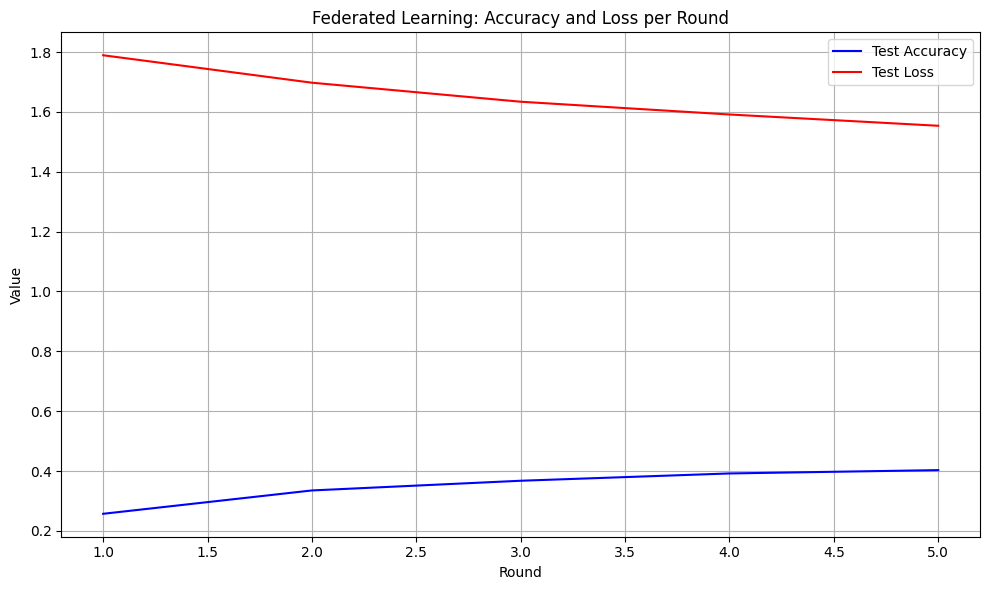

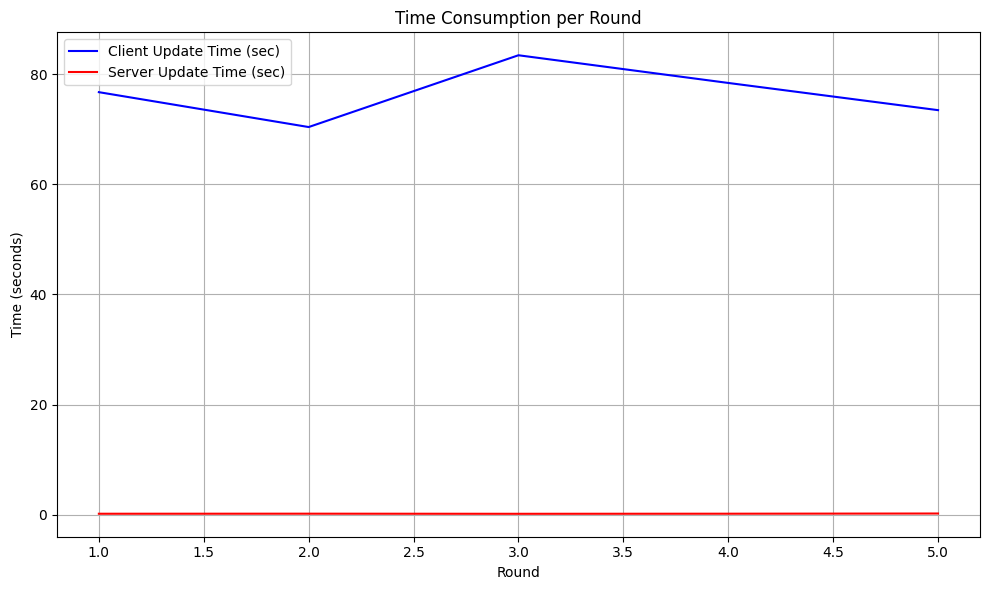

In [10]:
import kagglehub
import matplotlib.pyplot as plt  # Added for visualization

# ---------------- Library Imports ----------------
import os
import time
import numpy as np
from glob import glob
from PIL import Image
import tensorflow as tf
import tensorflow_federated as tff
import tenseal as ts
from sklearn.model_selection import train_test_split
import threading  # Added for parallel client updates

# Enable TensorFlow debugging for device placement
tf.debugging.set_log_device_placement(True)

# Allow GPU if available, fallback to CPU
os.environ["JAX_PLATFORM_NAME"] = "cpu"  # Default to CPU
# Uncomment below for GPU if available
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Config: Define constants for model and training
IMG_SIZE, NUM_CLASSES, NUM_CLIENTS = 48, 7, 2
BATCH_SIZE, EPOCHS, ROUNDS = 128, 3, 5  # Adjusted for better training
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# ---------------- Dataset Load ----------------
def load_images_from_folder(folder, label):
    """Load images from a folder and assign corresponding label."""
    images, labels = [], []
    for img_path in glob(os.path.join(folder, '*.jpg')):
        try:
            # Convert to grayscale and resize image
            img = Image.open(img_path).convert('L').resize((IMG_SIZE, IMG_SIZE))
            images.append(np.array(img))
            labels.append(label)
        except:
            continue
    return np.array(images), np.array(labels)

def load_dataset(base_path, fraction=0.5):  # Increased to 50% for better learning
    """Load and preprocess FER2013 dataset with specified fraction."""
    X, y = [], []
    for idx, emo in enumerate(EMOTIONS):
        folder = os.path.join(base_path, emo)
        if not os.path.exists(folder):
            print(f"Warning: {folder} not found")
            continue
        # Load and label images for each emotion
        imgs, lbls = load_images_from_folder(folder, idx)
        print(f"Loaded {len(imgs)} images for {emo}")
        num_samples = int(len(imgs) * fraction)
        indices = np.random.choice(len(imgs), num_samples, replace=False)
        X.append(imgs[indices])
        y.append(lbls[indices])
    if not X:
        print("Error: No images loaded")
        return np.array([]), np.array([])
    # Normalize and reshape data for model input
    X = np.concatenate(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
    y = tf.keras.utils.to_categorical(np.concatenate(y), NUM_CLASSES)
    print(f"Dataset: X shape={X.shape}, y shape={y.shape}")
    return X, y

# ---------------- Federated Prep ----------------
def create_federated_data(X, y):
    """Create federated datasets for clients."""
    size = len(X) // NUM_CLIENTS
    # Split dataset into batches for each client
    client_data = [
        tf.data.Dataset.from_tensor_slices((X[i*size:(i+1)*size], y[i*size:(i+1)*size]))
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)  # Pre-fetch for performance
        for i in range(NUM_CLIENTS)
    ]
    for i, ds in enumerate(client_data):
        print(f"Client {i} dataset element_spec: {ds.element_spec}")
    return client_data

# ---------------- Model ----------------
def create_keras_model():
    """Define a larger CNN model for better accuracy."""
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Add dropout to prevent overfitting
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    print("Model summary:")
    model.summary()
    return model

def model_fn():
    """Wrap Keras model for TFF compatibility."""
    return tff.learning.models.from_keras_model(
        create_keras_model(),
        input_spec=client_data[0].element_spec,
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )

# ---------------- TenSEAL ----------------
def initialize_tenseal_context():
    """Initialize TenSEAL CKKS context with optimized parameters."""
    try:
        ctx = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=4096,  # Reduced for speed
            coeff_mod_bit_sizes=[30, 20, 30]  # Adjusted for faster computation
        )
        ctx.global_scale = 2 ** 20
        ctx.generate_galois_keys()
        print("TenSEAL context initialized")
        return ctx
    except Exception as e:
        print(f"Error initializing TenSEAL: {e}")
        exit()

def encrypt_array(ctx, array):
    """Encrypt array using CKKS for secure computation."""
    try:
        print(f"Encrypting array of size {array.size}")
        return ts.ckks_vector(ctx, array.tolist())
    except Exception as e:
        print(f"Error encrypting array: {e}")
        return None

def decrypt_array(enc_array):
    """Decrypt CKKS encrypted array for aggregation."""
    try:
        result = np.array(enc_array.decrypt())
        print(f"Decrypted array shape: {result.shape}")
        return result
    except Exception as e:
        print(f"Error decrypting array: {e}")
        return None

# ---------------- Client Update ----------------
def client_update_fn(model_weights, dataset, ctx):
    """Perform client-side model update and encrypt weight deltas."""
    start_time = time.time()
    model = create_keras_model()
    model.set_weights(model_weights)
    opt = tf.keras.optimizers.Adam()  # Use Adam for better training

    # Train on client data batch by batch
    for x_batch, y_batch in dataset:
        with tf.GradientTape() as tape:
            preds = model(x_batch)
            loss = tf.keras.losses.CategoricalCrossentropy()(y_batch, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))

    # Compute and encrypt weight updates
    new_weights = model.get_weights()
    delta = [nw - ow for nw, ow in zip(new_weights, model_weights)]
    enc_delta = [encrypt_array(ctx, d.flatten()) for d in delta]
    if any(d is None for d in enc_delta):
        print("Error: Failed to encrypt deltas")
        return None, 0
    elapsed = time.time() - start_time
    print(f"Client update took {elapsed:.2f} sec")
    return enc_delta, elapsed

# ---------------- Server Update ----------------
def server_update_fn(encrypted_deltas, ctx, shapes, model_weights):
    """Aggregate encrypted deltas and update server model."""
    start_time = time.time()
    agg = []
    print(f"Processing {len(encrypted_deltas)} encrypted deltas")
    # Aggregate encrypted weight updates from clients
    for i in range(len(encrypted_deltas[0])):
        s = encrypted_deltas[0][i]
        for d in encrypted_deltas[1:]:
            s += d[i]
        s *= (1.0 / len(encrypted_deltas))
        agg.append(s)

    # Decrypt and reshape aggregated updates
    dec_deltas = [decrypt_array(e).reshape(shape) for e, shape in zip(agg, shapes)]
    if any(d is None for d in dec_deltas):
        print("Error: Failed to decrypt deltas")
        return model_weights, 0
    # Apply updates to server model weights
    new_weights = [w + d for w, d in zip(model_weights, dec_deltas)]
    elapsed = time.time() - start_time
    print(f"Server update took {elapsed:.2f} sec")
    return new_weights, elapsed

# ---------------- Training ----------------
# Load and split dataset for training and testing
dataset_path = os.path.join(path, "train")
X, y = load_dataset(dataset_path)
if len(X) == 0 or len(y) == 0:
    print("Error: Empty dataset")
    exit()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
client_data = create_federated_data(X_train, y_train)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(f"Test dataset element_spec: {test_ds.element_spec}")

for x_batch, y_batch in test_ds.take(1):
    print(f"Sample batch: X shape={x_batch.shape}, y shape={y_batch.shape}")

# Init: Set up model, weights, and encryption context
model = create_keras_model()
weights = model.get_weights()
shapes = [w.shape for w in weights]
tenseal_ctx = initialize_tenseal_context()

# Track metrics for visualization
accuracies, losses, round_numbers = [], [], []
client_times, server_times = [], []

print("Homomorphic Federated Training Start")
start = time.time()

# Parallel client update function for threading
def parallel_client_update(weights, dataset, ctx, result_list, index):
    """Wrapper for client update to use with threading."""
    result = client_update_fn(weights, dataset, ctx)
    result_list[index] = result

# Main training loop for federated learning
for rnd in range(1, ROUNDS + 1):
    print(f"\nRound {rnd} starts")
    round_start = time.time()
    # Use threading for parallel client updates
    result_list = [None] * NUM_CLIENTS
    threads = []
    for i, cdata in enumerate(client_data):
        t = threading.Thread(target=parallel_client_update, args=(weights, cdata, tenseal_ctx, result_list, i))
        threads.append(t)
        t.start()
    for t in threads:
        t.join()

    # Separate encrypted deltas and times
    encrypted_deltas, client_round_times = [], []
    for result in result_list:
        if result is None:
            print(f"Round {rnd}: Client update failed")
            continue
        enc_delta, elapsed = result
        encrypted_deltas.append(enc_delta)
        client_round_times.append(elapsed)
    # Average client times per round for visualization
    avg_client_time = np.mean(client_round_times) if client_round_times else 0
    client_times.append(avg_client_time)

    # Aggregate and update server model
    weights, server_time = server_update_fn(encrypted_deltas, tenseal_ctx, shapes, weights)
    server_times.append(server_time)

    # Compile and evaluate model on test data
    model.set_weights(weights)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    try:
        loss, acc = model.evaluate(test_ds, verbose=0)
        print(f"Round {rnd}: Test Accuracy={acc:.4f}, Loss={loss:.4f}")
        accuracies.append(acc)
        losses.append(loss)
        round_numbers.append(rnd)  # Numeric rounds for plotting
    except Exception as e:
        print(f"Round {rnd}: Test evaluation failed: {e}")
    print(f"Round {rnd} took {time.time() - round_start:.2f} sec")

end = time.time()
print(f"\nFinal Accuracy: {acc:.4f}")
print(f"Total Time: {end - start:.2f} sec")

# ---------------- Visualization Functions ----------------
def plot_metrics(rounds, accuracies, losses):
    """Plot accuracy and loss per round using Matplotlib."""
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, accuracies, 'b-', label='Test Accuracy')
    plt.plot(rounds, losses, 'r-', label='Test Loss')
    plt.xlabel('Round')
    plt.ylabel('Value')
    plt.title('Federated Learning: Accuracy and Loss per Round')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

def plot_times(rounds, client_times, server_times):
    """Plot client and server update times per round using Matplotlib."""
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, client_times, 'b-', label='Client Update Time (sec)')
    plt.plot(rounds, server_times, 'r-', label='Server Update Time (sec)')
    plt.xlabel('Round')
    plt.ylabel('Time (seconds)')
    plt.title('Time Consumption per Round')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

# ---------------- Generate Graphs ----------------
print("Generating Accuracy and Loss Graph...")
plot_metrics(round_numbers, accuracies, losses)

print("Generating Time Consumption Graph...")
plot_times(round_numbers, client_times, server_times)

plt.show()  # Display all plots